## Project description
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.  
В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.  
Вам нужно построить модель для определения стоимости.
Заказчику важны:  
(1) качество предсказания;  
(2) скорость предсказания;  
(3) время обучения.

## Importing packages

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

## Data preparation

### Reading

In [29]:
pth1 = '/datasets/autos.csv'
pth2 = 'autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong. Please, check file path.')

In [30]:
df.columns = df.columns.map(str.lower)
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Cleaning

In [31]:
# Удаление дубликатов
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [32]:
# Удаляю признаки, которые не повлияют на обучение моделей
df = df.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode', 'registrationmonth', 'lastseen'], axis=1)

In [33]:
# Оставлю в datafame только те строки, где мощность двигателя 'power' < 1000 л.с. Это логично, потому-что мощность > 1000 л.с.
# крайне редко встречается и скорее всего это ошибка в данных. Нулю мощность тоже равна быть не может. Обычно в машине более 50 л.с. 
df = df[(df['power'] < 1000) & (df['power'] > 49)]
# Также 'registrationyear' должен быть в пределах разумных годов. Ранее было показано, что есть выбросы как в плюс так и в минус.
df = df.query('1980 < registrationyear < 2018')
# 'price' равным нулю тоже быть не может. Все, что ниже 100 Евро в 'price' - уберу. Если цена близка к 100 Евро, то, скорей всего
# машина битая или распродается по частям. Также уберу 2% выбросов от 20000, т.е. оставлю все, что < 19600
df = df[(df['price'] < 19000) & (df['price'] > 100)] 

In [34]:
# Проверим сколько NaN
display(df.isna().sum())
# Заменяю 'yes' и 'no' на 1 и 0
df['notrepaired'] = df['notrepaired'].map({'yes':1, 'no':0})
# Заменю NaN на 0, т.к скорее всего NaN означает, что машина не ремонтировалась, иначе была бы указана 1
df['notrepaired'] = df['notrepaired'].fillna(0)
df['notrepaired'] = df['notrepaired'].astype('int64')
# Удалю остальные NaN, т.к. это будет около 5% данных
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

price                   0
vehicletype         17424
registrationyear        0
gearbox              5239
power                   0
model               10863
kilometer               0
fueltype            17321
brand                   0
notrepaired         43490
dtype: int64

### Categorical columns

In [35]:
# Определяем столбцы, которые будут категориальными
cat_cols = list(df.select_dtypes(include='object').columns)
# Конвертируем
df[cat_cols] = df[cat_cols].astype('category')

In [36]:
# Таблица после редактирования
display(df.describe())
display(df.info())

,price,registrationyear,power,kilometer,notrepaired
count,254907.000000,254907.000000,254907.000000,254907.000000,254907.000000
mean,4987.847662,2003.056542,122.689397,128526.658742,0.091594
std,4465.980475,5.497544,52.853121,36150.799972,0.288453
min,101.000000,1981.000000,50.000000,5000.000000,0.000000
25%,1500.000000,1999.000000,82.000000,125000.000000,0.000000
50%,3499.000000,2003.000000,115.000000,150000.000000,0.000000
75%,7250.000000,2007.000000,150.000000,150000.000000,0.000000
max,18999.000000,2017.000000,999.000000,150000.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254907 entries, 0 to 254906
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   price             254907 non-null  int64   
 1   vehicletype       254907 non-null  category
 2   registrationyear  254907 non-null  int64   
 3   gearbox           254907 non-null  category
 4   power             254907 non-null  int64   
 5   model             254907 non-null  category
 6   kilometer         254907 non-null  int64   
 7   fueltype          254907 non-null  category
 8   brand             254907 non-null  category
 9   notrepaired       254907 non-null  int64   
dtypes: category(5), int64(5)
memory usage: 11.2 MB


None

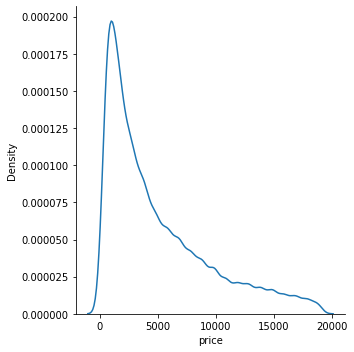

In [37]:
# Посмотрю на распределение price
sns.displot(data=df, x='price', kind='kde')
plt.show()

Вывод.  
Данные были подготовлены для построения моделей. Ненужные признаки были удалены. Строки, содержащие NaN были удалены. Столбцы типа 'object' были переведены в 'category'.

## Data splitting

In [38]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Data scaling

In [39]:
scaler = StandardScaler()
numeric = ['registrationyear','power','kilometer']
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [40]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(203925, 9) (203925,)
(50982, 9) (50982,)


## Custom Class to adjust models

In [41]:
class PredictionModel:
   
    def __init__(self, model, cat_features=None):
        self.cat_features = cat_features
        self.model = model
        self.data_list = []
               
    def train(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.start = time.time()
        self.model.fit(X_train, y_train, self.cat_features)
        self.end = time.time()
        self.time_train = abs(self.start - self.end)
        self.data_list.append(round(self.time_train, 3))
    
    def predict(self, y_test):
        self.y_test = y_test
        self.start = time.time()
        self.predicted_test = self.model.predict(X_test)
        self.end = time.time()
        self.time_predict = abs(self.start - self.end)
        self.data_list.append(round(self.time_predict, 3))
    
    def rmse(self):
        self.mse = mean_squared_error(self.y_test, self.predicted_test)
        self.rmse = self.mse**0.5
        self.data_list.append(round(self.rmse, 3))
        
    def get_data(self):
        print(f'Train time(s): {self.data_list[0]}, Prediction time (s): {self.data_list[1]}, RMSE: {self.data_list[2]}')
        return self.data_list
    
    def get_importances(self):              
        self.feat_importance = self.model.feature_importances_
        self.cols = self.X_train.columns        
        return self.feat_importance
    
    def get_cols(self):
        return self.X_train.columns
    
    def get_graph(self):
        self.df_importances = pd.DataFrame(sorted(zip(self.get_importances(), self.get_cols())), columns=['Value','Feature'])
        sns.barplot(x='Value', y='Feature', data=self.df_importances.sort_values(by='Value', ascending=False))
        plt.title('Feature importance')
        plt.tight_layout()
        plt.show()

## LightGBM (Model 0)

In [42]:
model_0 = PredictionModel(LGBMRegressor(random_state=0))
model_0.train(X_train, y_train)
model_0.predict(y_test)
model_0.rmse()
model_0.get_data()

Train time(s): 0.374, Prediction time (s): 0.056, RMSE: 1483.12


[0.374, 0.056, 1483.12]

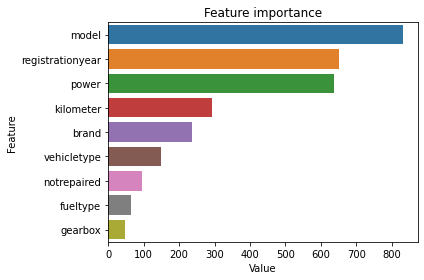

In [43]:
model_0.get_graph()

## LightGBM (Model 1)

In [44]:
model_1 = PredictionModel(LGBMRegressor(num_leaves=300, 
                                 max_depth=- 1, 
                                 learning_rate=0.1, 
                                 n_estimators=150, 
                                 random_state=0))
model_1.train(X_train, y_train)
model_1.predict(y_test)
model_1.rmse()
model_1.get_data()

Train time(s): 1.714, Prediction time (s): 0.173, RMSE: 1396.369


[1.714, 0.173, 1396.369]

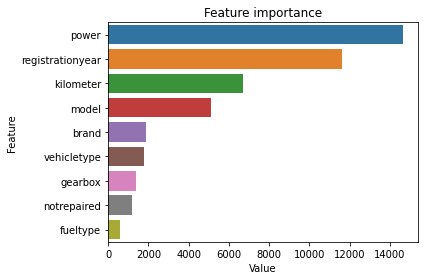

In [45]:
model_1.get_graph()

## LightGBM (Model 2)


In [46]:
model_2 = PredictionModel(LGBMRegressor(num_leaves=300, 
                                 max_depth=- 1, 
                                 learning_rate=0.1, 
                                 n_estimators=200, 
                                 random_state=0))
model_2.train(X_train, y_train)
model_2.predict(y_test)
model_2.rmse()
model_2.get_data()

Train time(s): 2.096, Prediction time (s): 0.208, RMSE: 1394.644


[2.096, 0.208, 1394.644]

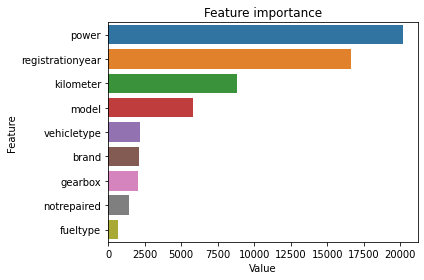

In [47]:
model_2.get_graph()

## LightGBM (Model 3)


In [48]:
model_3 = PredictionModel(LGBMRegressor(num_leaves=300, 
                                 max_depth=- 1, 
                                 learning_rate=0.1, 
                                 n_estimators=300, 
                                 random_state=0))
model_3.train(X_train, y_train)
model_3.predict(y_test)
model_3.rmse()
model_3.get_data()

Train time(s): 2.836, Prediction time (s): 0.29, RMSE: 1391.751


[2.836, 0.29, 1391.751]

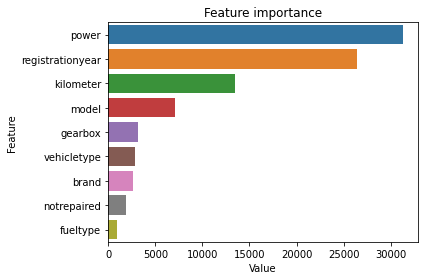

In [49]:
model_3.get_graph()

## CatBoost (Model 4)

In [50]:
model_4 = PredictionModel(CatBoostRegressor(), cat_features=cat_cols)
model_4.train(X_train, y_train)
model_4.predict(y_test)
model_4.rmse()
model_4.get_data()

Learning rate set to 0.094858
0:	learn: 4173.6288948	total: 48.6ms	remaining: 48.5s
1:	learn: 3913.2764406	total: 92.1ms	remaining: 46s
2:	learn: 3685.9910893	total: 123ms	remaining: 40.8s
3:	learn: 3476.8891001	total: 153ms	remaining: 38.2s
4:	learn: 3294.8764226	total: 184ms	remaining: 36.7s
5:	learn: 3125.0361913	total: 215ms	remaining: 35.6s
6:	learn: 2974.6993929	total: 241ms	remaining: 34.2s
7:	learn: 2847.3098970	total: 266ms	remaining: 33s
8:	learn: 2731.0428066	total: 297ms	remaining: 32.7s
9:	learn: 2628.4436092	total: 327ms	remaining: 32.3s
10:	learn: 2541.7129474	total: 351ms	remaining: 31.6s
11:	learn: 2462.9440982	total: 372ms	remaining: 30.6s
12:	learn: 2392.7280344	total: 397ms	remaining: 30.2s
13:	learn: 2320.3686008	total: 423ms	remaining: 29.8s
14:	learn: 2265.7468362	total: 453ms	remaining: 29.8s
15:	learn: 2208.9419184	total: 473ms	remaining: 29.1s
16:	learn: 2161.5274386	total: 490ms	remaining: 28.3s
17:	learn: 2121.7769267	total: 517ms	remaining: 28.2s
18:	learn:

153:	learn: 1585.1965020	total: 3.98s	remaining: 21.9s
154:	learn: 1584.5532049	total: 4s	remaining: 21.8s
155:	learn: 1584.0138618	total: 4.03s	remaining: 21.8s
156:	learn: 1583.2316933	total: 4.05s	remaining: 21.7s
157:	learn: 1582.3114135	total: 4.07s	remaining: 21.7s
158:	learn: 1581.7037555	total: 4.09s	remaining: 21.6s
159:	learn: 1580.7848828	total: 4.11s	remaining: 21.6s
160:	learn: 1580.0946642	total: 4.14s	remaining: 21.6s
161:	learn: 1579.7776479	total: 4.17s	remaining: 21.6s
162:	learn: 1578.5714816	total: 4.2s	remaining: 21.5s
163:	learn: 1578.0018117	total: 4.22s	remaining: 21.5s
164:	learn: 1577.7401264	total: 4.25s	remaining: 21.5s
165:	learn: 1576.9637098	total: 4.27s	remaining: 21.5s
166:	learn: 1576.2019183	total: 4.3s	remaining: 21.4s
167:	learn: 1575.7486106	total: 4.32s	remaining: 21.4s
168:	learn: 1575.0059614	total: 4.34s	remaining: 21.4s
169:	learn: 1574.3166558	total: 4.37s	remaining: 21.4s
170:	learn: 1573.2849851	total: 4.4s	remaining: 21.3s
171:	learn: 1572

307:	learn: 1519.5019212	total: 7.77s	remaining: 17.5s
308:	learn: 1519.2157004	total: 7.79s	remaining: 17.4s
309:	learn: 1518.8169200	total: 7.82s	remaining: 17.4s
310:	learn: 1518.3368434	total: 7.84s	remaining: 17.4s
311:	learn: 1518.0053840	total: 7.86s	remaining: 17.3s
312:	learn: 1517.7718382	total: 7.89s	remaining: 17.3s
313:	learn: 1517.3458622	total: 7.91s	remaining: 17.3s
314:	learn: 1517.0405382	total: 7.95s	remaining: 17.3s
315:	learn: 1516.4534787	total: 7.97s	remaining: 17.3s
316:	learn: 1516.2557333	total: 7.99s	remaining: 17.2s
317:	learn: 1516.1409896	total: 8.02s	remaining: 17.2s
318:	learn: 1515.8398369	total: 8.04s	remaining: 17.2s
319:	learn: 1515.6287711	total: 8.06s	remaining: 17.1s
320:	learn: 1515.2033099	total: 8.08s	remaining: 17.1s
321:	learn: 1515.0994482	total: 8.11s	remaining: 17.1s
322:	learn: 1514.7583230	total: 8.14s	remaining: 17.1s
323:	learn: 1514.3301719	total: 8.16s	remaining: 17s
324:	learn: 1513.9803024	total: 8.18s	remaining: 17s
325:	learn: 15

461:	learn: 1485.3819973	total: 11.6s	remaining: 13.5s
462:	learn: 1485.1984468	total: 11.6s	remaining: 13.4s
463:	learn: 1485.0907915	total: 11.6s	remaining: 13.4s
464:	learn: 1484.9001474	total: 11.6s	remaining: 13.4s
465:	learn: 1484.8230962	total: 11.7s	remaining: 13.4s
466:	learn: 1484.6021937	total: 11.7s	remaining: 13.3s
467:	learn: 1484.2685704	total: 11.7s	remaining: 13.3s
468:	learn: 1484.1325536	total: 11.7s	remaining: 13.3s
469:	learn: 1483.8181170	total: 11.8s	remaining: 13.3s
470:	learn: 1483.6197245	total: 11.8s	remaining: 13.3s
471:	learn: 1483.4694171	total: 11.8s	remaining: 13.2s
472:	learn: 1483.2556295	total: 11.8s	remaining: 13.2s
473:	learn: 1483.0379188	total: 11.9s	remaining: 13.2s
474:	learn: 1482.8835650	total: 11.9s	remaining: 13.2s
475:	learn: 1482.6871091	total: 11.9s	remaining: 13.1s
476:	learn: 1482.5731977	total: 12s	remaining: 13.1s
477:	learn: 1482.2510035	total: 12s	remaining: 13.1s
478:	learn: 1482.0435507	total: 12s	remaining: 13.1s
479:	learn: 1481

612:	learn: 1462.2409445	total: 15.4s	remaining: 9.74s
613:	learn: 1462.0114220	total: 15.4s	remaining: 9.71s
614:	learn: 1461.8391121	total: 15.5s	remaining: 9.69s
615:	learn: 1461.6159894	total: 15.5s	remaining: 9.67s
616:	learn: 1461.5308926	total: 15.5s	remaining: 9.65s
617:	learn: 1461.3411273	total: 15.6s	remaining: 9.62s
618:	learn: 1461.3190965	total: 15.6s	remaining: 9.6s
619:	learn: 1461.1965511	total: 15.6s	remaining: 9.57s
620:	learn: 1461.1746343	total: 15.6s	remaining: 9.54s
621:	learn: 1461.1014330	total: 15.7s	remaining: 9.52s
622:	learn: 1460.9935615	total: 15.7s	remaining: 9.49s
623:	learn: 1460.9175477	total: 15.7s	remaining: 9.46s
624:	learn: 1460.7702783	total: 15.7s	remaining: 9.44s
625:	learn: 1460.4185181	total: 15.8s	remaining: 9.41s
626:	learn: 1460.3854553	total: 15.8s	remaining: 9.39s
627:	learn: 1460.2457859	total: 15.8s	remaining: 9.36s
628:	learn: 1460.0811668	total: 15.8s	remaining: 9.34s
629:	learn: 1460.0272168	total: 15.9s	remaining: 9.31s
630:	learn:

768:	learn: 1444.7210249	total: 19.5s	remaining: 5.84s
769:	learn: 1444.5882334	total: 19.5s	remaining: 5.82s
770:	learn: 1444.4940249	total: 19.5s	remaining: 5.79s
771:	learn: 1444.3480007	total: 19.5s	remaining: 5.77s
772:	learn: 1444.2803581	total: 19.6s	remaining: 5.75s
773:	learn: 1444.1389239	total: 19.6s	remaining: 5.72s
774:	learn: 1444.0963487	total: 19.6s	remaining: 5.69s
775:	learn: 1443.8875129	total: 19.6s	remaining: 5.67s
776:	learn: 1443.8233628	total: 19.7s	remaining: 5.64s
777:	learn: 1443.6234079	total: 19.7s	remaining: 5.62s
778:	learn: 1443.5975748	total: 19.7s	remaining: 5.59s
779:	learn: 1443.4765286	total: 19.7s	remaining: 5.56s
780:	learn: 1443.4352892	total: 19.8s	remaining: 5.54s
781:	learn: 1443.3906599	total: 19.8s	remaining: 5.51s
782:	learn: 1443.2914291	total: 19.8s	remaining: 5.49s
783:	learn: 1443.2883850	total: 19.8s	remaining: 5.46s
784:	learn: 1443.2315514	total: 19.8s	remaining: 5.43s
785:	learn: 1443.1821555	total: 19.9s	remaining: 5.41s
786:	learn

921:	learn: 1431.1112962	total: 23.4s	remaining: 1.98s
922:	learn: 1431.0597648	total: 23.4s	remaining: 1.95s
923:	learn: 1431.0354230	total: 23.4s	remaining: 1.93s
924:	learn: 1430.9771916	total: 23.4s	remaining: 1.9s
925:	learn: 1430.8634195	total: 23.4s	remaining: 1.87s
926:	learn: 1430.7365907	total: 23.5s	remaining: 1.85s
927:	learn: 1430.5864620	total: 23.5s	remaining: 1.82s
928:	learn: 1430.5149968	total: 23.5s	remaining: 1.8s
929:	learn: 1430.3972268	total: 23.6s	remaining: 1.77s
930:	learn: 1430.1591250	total: 23.6s	remaining: 1.75s
931:	learn: 1429.9863940	total: 23.6s	remaining: 1.72s
932:	learn: 1429.9470537	total: 23.6s	remaining: 1.7s
933:	learn: 1429.8507397	total: 23.7s	remaining: 1.67s
934:	learn: 1429.7823057	total: 23.7s	remaining: 1.65s
935:	learn: 1429.7287566	total: 23.7s	remaining: 1.62s
936:	learn: 1429.6601240	total: 23.7s	remaining: 1.59s
937:	learn: 1429.6141921	total: 23.8s	remaining: 1.57s
938:	learn: 1429.4633768	total: 23.8s	remaining: 1.54s
939:	learn: 1

[25.639, 0.053, 1473.558]

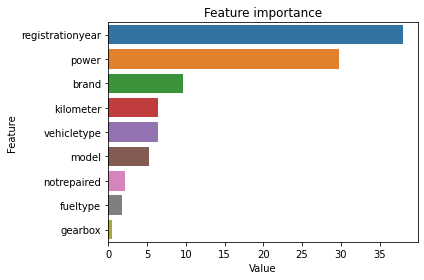

In [51]:
model_4.get_graph()

## LinearRegression (Model 5)

In [52]:
df_lm = df.copy()

df_lm = pd.get_dummies(df_lm, drop_first=True)

X = df_lm.drop('price', axis=1)
y = df_lm['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_5 = PredictionModel(LinearRegression())
model_5.train(X_train, y_train)
model_5.predict(y_test)
model_5.rmse()
model_5.get_data()

Train time(s): 2.593, Prediction time (s): 0.041, RMSE: 2239.599


[2.593, 0.041, 2239.599]

## Final table

In [53]:
df_models = pd.DataFrame(data=[model_0.get_data(), 
                               model_1.get_data(), 
                               model_2.get_data(), 
                               model_3.get_data(), 
                               model_4.get_data(), 
                               model_5.get_data()], 
                         columns=['Time train (s)', 'Time predict (s)', 'RMSE'], 
                         index=['Model 0', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])

Train time(s): 0.374, Prediction time (s): 0.056, RMSE: 1483.12
Train time(s): 1.714, Prediction time (s): 0.173, RMSE: 1396.369
Train time(s): 2.096, Prediction time (s): 0.208, RMSE: 1394.644
Train time(s): 2.836, Prediction time (s): 0.29, RMSE: 1391.751
Train time(s): 25.639, Prediction time (s): 0.053, RMSE: 1473.558
Train time(s): 2.593, Prediction time (s): 0.041, RMSE: 2239.599


In [54]:
display(df_models)

,Time train (s),Time predict (s),RMSE
Model 0,0.374,0.056,1483.120
Model 1,1.714,0.173,1396.369
Model 2,2.096,0.208,1394.644
Model 3,2.836,0.290,1391.751
Model 4,25.639,0.053,1473.558
Model 5,2.593,0.041,2239.599


## Conclusion

Вывод.  
Данные были изучены и почищены. Были обучены разные модели и получена таблица для сравнения параметров и оптимального выбора среди данных моделей.